In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
import re
import seaborn as sns
import random
from sklearn import svm
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import re
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.utils.np_utils import to_categorical


In [3]:
# test data and test data directory 

data_dir = "/content/drive/MyDrive/ELEC378_FinalProject/data/data"

test_dir = "/content/drive/MyDrive/ELEC378_FinalProject/test/test"



Containis function for feature extraction. Takes a directory and a boolean indicating wheather to split the data or not. For cross validation use the data directory (labeled data) and split = true. Run all the way to the cell that prints out accuracy score. For testing model on the unlabled data in test folder (those that are named sample001, etc), run the cells below the accuracy score cell will give you a .csv file ready for submission on kaggle. 

In [4]:
#@title Feature Extraction func
def FeatureExtraction (dir, split=True): 
 
  '''
  Function for feature extraction. Change this section to change what features we are using. 

  input: a directory of the data. Will split to test and train, a boolean: if split is true, will extract features and labels and store them in 4 arrays:
  train_data, train_label, test_data, test_label. if split is false, function will extract all data provided in the directory and output 2 arrays with values 2 arrays that are empty. 
  Use labeled data and split = false will give you  (train_data, train_label); use unlabled data and split = false will give you (test_data, test_label).

  output: data matrix and lables for both test and train. 

  '''
  audio_files = [f for f in os.listdir(dir) if f.endswith(".wav")]
  
  train_files, test_files = train_test_split(audio_files, test_size=0.2)

  train_data = []
  train_label= []
  test_data = []
  test_label = []  
  
  
  for file_name in audio_files:

      # Load audio
      file_path = os.path.join(dir, file_name)
      raw_audio, sr = librosa.load(file_path)

      # if audio is too short, append zeros after it. 
      if np.shape(raw_audio)[0] < 80000: 
          padded_audio = np.pad(raw_audio, [(0, 80000 - np.shape(raw_audio)[0])], mode='constant')
      else:
          padded_audio = raw_audio

      # now slice so that we guarantee that each array has the same length
      audio = padded_audio[20000:80000]

      # feature extraction

      mfccs = librosa.feature.mfcc(y=audio, sr = 22050, n_mfcc = 100)

      #chroma_stft = librosa.feature.chroma_stft(y = audio, sr=22050)
      #mel_spec = librosa.feature.melspectrogram(y = audio, sr = 22050, n_mels = 5)
      #gfccs = librosa.feature.gfcc(y, sr=sr, n_mfcc=20)

      # Concatenate
      #features = np.concatenate([mfccs.flatten()])
      features = mfccs

      label_map = {'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}
      label = file_name.split(".")[0]

      #unlabeled data
      if label[:-3] == "sample":
        test_data.append(features)
        test_label.append(label)

      #labeled data
      else:
        if split: 
          if file_name in train_files:
            train_data.append(features)
            label = re.sub('[^a-z]', "", label)
            train_label.append(label_map[label])

          elif file_name in test_files: 
            test_data.append(features)
            label = re.sub('[^a-z]', "", label)
            test_label.append(label_map[label])

        elif not split: 
          
          train_data.append(features)
          label = re.sub('[^a-z]', "", label)
          train_label.append(label_map[label])
  

  train_data = np.array(train_data)
  train_label = np.array(train_label)
  test_data = np.array(test_data)
  test_label = np.array(test_label) 

  print("mfccs size is:", np.shape(mfccs))
  return train_data, train_label, test_data, test_label



In [43]:
X_train, y_train, X_test, y_test = FeatureExtraction(data_dir, split = True)
y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)
print(np.shape(X_train))

mfccs size is: (100, 118)
(900, 100, 118)


In [32]:
#@title SVM
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(kernel = "linear"))
clf.fit(X_train, y_train)

y_predicted= clf.predict(X_test)

accuracy = accuracy_score(y_test, y_predicted)

print(accuracy)

ValueError: ignored

Below is for unlabeled test data and importing a csv


In [ ]:
clf = make_pipeline(StandardScaler(), SVC(kernel = "linear"))
clf.fit(X_train, y_train)

y_predicted= clf.predict(X_test)

In [9]:
import keras
from keras.layers import Conv1D, Embedding, Dropout, MaxPooling1D, GlobalMaxPooling1D, Dense
from keras.optimizers import Adam
from keras import Model
from keras.callbacks import EarlyStopping

In [10]:

num_classes = 8
def build_cnn(input_shape, num_classes):
    model = tf.keras.Sequential()
    
    # Convolutional layers
    model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='valid', input_shape=input_shape))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='valid'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='valid'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.MaxPooling2D())

    # Dense layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Dense(num_classes))
    model.add(tf.keras.layers.Activation('softmax'))
    
    return model

Epoch 1/20
29/29 [==============================] - 6s 53ms/step - loss: 1.7021 - accuracy: 0.3900 - val_loss: 37.8960 - val_accuracy: 0.1333
Epoch 2/20
29/29 [==============================] - 1s 36ms/step - loss: 1.0799 - accuracy: 0.6133 - val_loss: 15.0712 - val_accuracy: 0.1333
Epoch 3/20
29/29 [==============================] - 1s 37ms/step - loss: 0.7878 - accuracy: 0.7311 - val_loss: 10.5467 - val_accuracy: 0.1333
Epoch 4/20
29/29 [==============================] - 1s 39ms/step - loss: 0.5560 - accuracy: 0.8322 - val_loss: 7.0232 - val_accuracy: 0.1333
Epoch 5/20
29/29 [==============================] - 1s 37ms/step - loss: 0.3698 - accuracy: 0.9044 - val_loss: 2.6968 - val_accuracy: 0.3022
Epoch 6/20
29/29 [==============================] - 1s 37ms/step - loss: 0.3028 - accuracy: 0.9244 - val_loss: 2.4306 - val_accuracy: 0.4622
Epoch 7/20
29/29 [==============================] - 1s 37ms/step - loss: 0.1995 - accuracy: 0.9633 - val_loss: 2.9972 - val_accuracy: 0.3067
Epoch 8/20

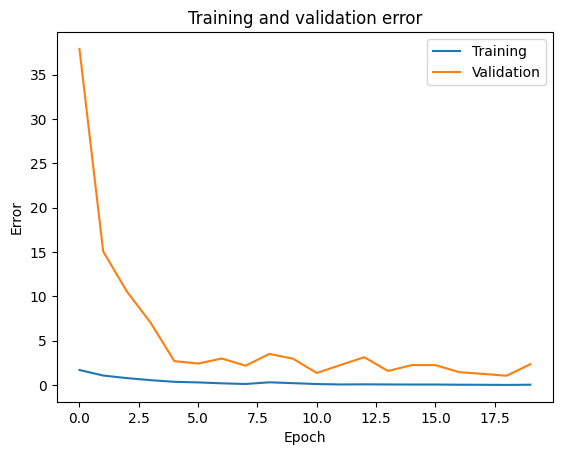

In [45]:
#num frames is number of wav files
model = build_cnn((X_train.shape[1], X_train.shape[2], 1), num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(X_train, y_train_ohe, batch_size=32, epochs=20, validation_data=(X_test, y_test_ohe))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [12]:
# extract all labeled data
X_train, y_train, dummy1, dummy2 = FeatureExtraction(data_dir, split = False)
# extract all unlabeled data
dummy1, dummy2, X_test, y_test = FeatureExtraction(test_dir, split = False)
y_train_ohe = to_categorical(y_train)


mfccs size is: (100, 118)
mfccs size is: (100, 118)


In [22]:
# this cell is to export a .csv file to submit (filename & predicted label) 
model = build_cnn((X_train.shape[1], X_train.shape[2], 1), num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.fit(X_train, y_train_ohe, batch_size=32, epochs=30)
y_predicted = model.predict(X_test)



Epoch 1/30
36/36 [==============================] - 4s 34ms/step - loss: 1.6863 - accuracy: 0.4044
Epoch 2/30
36/36 [==============================] - 1s 32ms/step - loss: 1.0042 - accuracy: 0.6516
Epoch 3/30
36/36 [==============================] - 1s 34ms/step - loss: 0.7059 - accuracy: 0.7689
Epoch 4/30
36/36 [==============================] - 1s 33ms/step - loss: 0.5421 - accuracy: 0.8382
Epoch 5/30
36/36 [==============================] - 1s 32ms/step - loss: 0.3851 - accuracy: 0.8916
Epoch 6/30
36/36 [==============================] - 1s 32ms/step - loss: 0.2118 - accuracy: 0.9547
Epoch 7/30
36/36 [==============================] - 1s 32ms/step - loss: 0.1478 - accuracy: 0.9742
Epoch 8/30
36/36 [==============================] - 1s 32ms/step - loss: 0.2191 - accuracy: 0.9476
Epoch 9/30
36/36 [==============================] - 1s 32ms/step - loss: 0.1870 - accuracy: 0.9582
Epoch 10/30
36/36 [==============================] - 1s 32ms/step - loss: 0.1079 - accuracy: 0.9804
Epoch 11/

In [26]:
print(np.shape(y_predicted))
y_predicted_ohv = np.argmax(y_predicted, axis = 1)
print(np.shape(y_predicted_ohv))

(315, 8)
(315,)


In [36]:
print(y_predicted_ohv)
label_map = {'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}

def dict_search(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key

y_predicted_label = []
for i in y_predicted_ohv: 
    val = dict_search(label_map, i)
    y_predicted_label.append(val)


print(y_predicted_label)

[1 3 6 1 6 4 6 0 6 3 3 1 2 2 6 6 6 2 3 2 7 1 3 6 0 1 1 1 7 0 6 1 6 1 2 2 3
 3 4 0 3 3 1 2 2 1 2 2 2 1 1 2 2 0 1 1 3 1 6 3 7 3 3 3 4 4 3 0 6 3 3 2 6 2
 3 7 3 2 3 4 6 2 2 7 3 4 6 2 3 6 3 7 2 6 1 7 2 1 1 3 2 6 2 3 1 3 6 1 3 4 6
 1 3 3 4 7 3 4 3 0 2 2 7 7 7 3 6 3 7 1 7 3 3 3 0 7 4 3 4 6 2 1 2 3 6 7 3 3
 7 4 1 3 6 0 3 6 3 3 4 6 1 3 1 7 1 6 1 7 2 1 3 1 3 3 6 0 7 3 1 1 2 3 7 1 2
 1 6 7 0 0 3 1 0 3 0 3 3 2 3 2 7 1 6 0 2 1 7 6 7 1 6 6 3 1 1 6 0 4 2 4 3 6
 6 3 6 1 1 2 6 4 1 3 3 3 3 6 6 1 2 5 3 3 4 1 4 1 3 3 0 3 1 2 6 6 7 3 6 4 3
 6 6 4 6 6 7 2 0 3 0 7 2 3 2 3 6 6 7 3 6 4 1 1 4 3 1 2 0 4 4 4 6 6 1 3 4 4
 1 2 1 3 1 3 1 3 4 3 1 2 3 3 1 3 3 1 2]
['calm', 'fearful', 'sad', 'calm', 'sad', 'happy', 'sad', 'angry', 'sad', 'fearful', 'fearful', 'calm', 'disgust', 'disgust', 'sad', 'sad', 'sad', 'disgust', 'fearful', 'disgust', 'surprised', 'calm', 'fearful', 'sad', 'angry', 'calm', 'calm', 'calm', 'surprised', 'angry', 'sad', 'calm', 'sad', 'calm', 'disgust', 'disgust', 'fearful', 'fearful', 'happy', 'an

In [38]:
import csv

with open('prediction.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['filename', 'label'])
    for i in range(len(y_test)):
      writer.writerow([y_test[i], y_predicted_label[i]])
file.close()
